**CASE STUDY HEALTHCARE DATA ANALYSIS (PART 3)**

**PART 3: Identify 10,000 Medicare patients who were involved in anomalous activities**

**1. Importing Libraries and datasets**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import scipy.stats as stats
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import pandas_profiling
%matplotlib inline

In [2]:
Patient_history = pd.read_csv("D:\\end_to_end\\Patient_history_samp.csv")
Review_patient = pd.read_csv("D:\\end_to_end\\Review_patient_history_samp.csv")
Review_transaction = pd.read_csv("D:\\end_to_end\\Rreview_transaction_coo.csv")
Transaction = pd.read_csv("D:\\end_to_end\\Transaction_coo.csv")

**2. Data Analysis and Data Preparation**

    Generally for anomaly detection, we aim to learn what is most representative of ‘normal’, 
    then anything outside of some threshold can be considered an anomaly
    
    Review_patient_history_samp.csv and Rreview_transaction_coo.csv datasets are the details for reviewed patient.
    Patient_history_samp.csv and Transaction_coo.csv are unclassified patient.
    
    We have to identify the cause/pattern for the review patient and based on that the unmarked patients needs to be marked.

In [3]:
Patient_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
id        500000 non-null int64
age       497470 non-null object
gender    500000 non-null object
income    497469 non-null object
dtypes: int64(1), object(3)
memory usage: 15.3+ MB


In [4]:
Review_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
id        5000 non-null int64
age       4974 non-null object
gender    5000 non-null object
income    4974 non-null object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


In [5]:
Patient_history.groupby('gender')['id'].nunique()

gender
F    274512
M    225488
Name: id, dtype: int64

In [6]:
Patient_history.groupby('income')['id'].nunique()

income
16000-23999    102492
24000-31999     75670
32000-47999     95899
48000+         115865
<16000         107543
Name: id, dtype: int64

In [7]:
Patient_history.groupby('age')['id'].nunique()

age
65-74    219329
75-84    128992
85+       64581
<65       84568
Name: id, dtype: int64

    Transforming categorical variables to numerical variables (grouping) for better data preprocesing
    and dropping the categorical variables

In [8]:
#function to get the income group indicator
def incometyp(patient):
    if (patient['income']  == '16000-23999'):
        return 2
    elif (patient['income']  == '24000-31999'):
        return 3
    elif (patient['income']  == '32000-47999'):
        return 4
    elif (patient['income']  == '48000+'):
        return 5
    else:
        return 1

In [9]:
#function to get the age group indicator
def agetyp(patient):
    if (patient['age']  == '65-74'):
        return 2
    elif (patient['age']  == '75-84'):
        return 3
    elif (patient['age']  == '85+'):
        return 4
    else:
        return 1

In [10]:
#function to get the gender group indicator
def gendertyp(patient):
    if (patient['gender']  == 'M'):
        return 1
    else:
        return 0

    Executing the functions on review and unmarked datasets

In [11]:
Patient_history['INCOME_GROUP'] = Patient_history.apply(incometyp, axis=1)

In [12]:
Patient_history['AGE_GROUP'] = Patient_history.apply(agetyp, axis=1)

In [13]:
Patient_history['GENDER_GROUP'] = Patient_history.apply(gendertyp, axis=1)

In [14]:
Review_patient['INCOME_GROUP'] = Review_patient.apply(incometyp, axis=1)

In [15]:
Review_patient['AGE_GROUP'] = Review_patient.apply(agetyp, axis=1)

In [16]:
Review_patient['GENDER_GROUP'] = Review_patient.apply(gendertyp, axis=1)

In [17]:
Patient_history.drop(['age', 'gender', 'income'], axis =1 , inplace = True)

In [18]:
Review_patient.drop(['age', 'gender', 'income'], axis =1 , inplace = True)

    Create dummies to count and sum the number of procedure used by patient
    Grouping them at patient level - so that there are 1 row per patient for the transaction dataset

    For full dataset - unlabeled

In [19]:
col_dummies=pd.get_dummies(Transaction['global_proc_id'], prefix='proc')
Transaction_cat = pd.concat([Transaction, col_dummies], axis=1)
Transaction_cat.drop( 'global_proc_id', axis = 1, inplace = True )

In [20]:
Transaction_grouped = pd.DataFrame(Transaction_cat[['id', 'count','proc_1' ,'proc_2' ,'proc_3' ,'proc_4' ,'proc_5' ,
                                                    'proc_6' ,'proc_7' ,'proc_8' ,'proc_9' ,'proc_10' ,'proc_11' ,
                                                    'proc_12' ,'proc_13' ,'proc_14' ,'proc_15' ,'proc_16' ,'proc_17' ,
                                                    'proc_18' ,'proc_19' ,'proc_20' ,'proc_21' ,'proc_22' ,'proc_23' ,
                                                    'proc_24' ,'proc_25' ,'proc_26' ,'proc_27' ,'proc_28' ,'proc_29' ,
                                                    'proc_30' ,'proc_31' ,'proc_32' ,'proc_33' ,'proc_34' ,'proc_35' ,
                                                    'proc_36' ,'proc_37' ,'proc_38' ,'proc_39' ,'proc_40' ,'proc_41' ,
                                                    'proc_42' ,'proc_43' ,'proc_44' ,'proc_45' ,'proc_46' ,'proc_47' ,
                                                    'proc_48' ,'proc_49' ,'proc_50' ,'proc_51' ,'proc_52' ,'proc_53' ,
                                                    'proc_54' ,'proc_55' ,'proc_56' ,'proc_57' ,'proc_58' ,'proc_59' ,
                                                    'proc_60' ,'proc_61' ,'proc_62' ,'proc_63' ,'proc_64' ,'proc_65' ,
                                                    'proc_66' ,'proc_67' ,'proc_68' ,'proc_69' ,'proc_70' ,'proc_71' ,
                                                    'proc_72' ,'proc_73' ,'proc_74' ,'proc_75' ,'proc_76' ,'proc_77' ,
                                                    'proc_78' ,'proc_79' ,'proc_80' ,'proc_81' ,'proc_82' ,'proc_83' ,
                                                    'proc_84' ,'proc_85' ,'proc_86' ,'proc_87' ,'proc_88' ,'proc_89' ,
                                                    'proc_90' ,'proc_91' ,'proc_92' ,'proc_93' ,'proc_94' ,'proc_95' ,
                                                    'proc_96' ,'proc_97' ,'proc_98' ,'proc_99' ,'proc_100' ,'proc_101' ,
                                                    'proc_102' ,'proc_103' ,'proc_104' ,'proc_105' ,'proc_106' ,
                                                    'proc_107' ,'proc_108' ,'proc_109' ,'proc_110' ,'proc_111' ,
                                                    'proc_112' ,'proc_113' ,'proc_114' ,'proc_115' ,'proc_116' ,
                                                    'proc_117' ,'proc_118' ,'proc_119' ,'proc_120' ,'proc_121' ,
                                                    'proc_122' ,'proc_123' ,'proc_124' ,'proc_125' ,'proc_126' ,
                                                    'proc_127' ,'proc_128' ,'proc_129' ,'proc_130']].groupby(['id']).agg({'count':'sum',
                                                                                         'proc_1' :'sum' ,
                                                                                         'proc_2' :'sum' ,
                                                                                         'proc_3' :'sum' ,
                                                                                         'proc_4' :'sum' ,
                                                                                         'proc_5' :'sum' ,
                                                                                         'proc_6' :'sum' ,
                                                                                         'proc_7' :'sum' ,
                                                                                         'proc_8' :'sum' ,
                                                                                         'proc_9' :'sum' ,
                                                                                         'proc_10' :'sum' ,
                                                                                         'proc_11' :'sum' ,
                                                                                         'proc_12' :'sum' ,
                                                                                         'proc_13' :'sum' ,
                                                                                         'proc_14' :'sum' ,
                                                                                         'proc_15' :'sum' ,
                                                                                         'proc_16' :'sum' ,
                                                                                         'proc_17' :'sum' ,
                                                                                         'proc_18' :'sum' ,
                                                                                         'proc_19' :'sum' ,
                                                                                         'proc_20' :'sum' ,
                                                                                         'proc_21' :'sum' ,
                                                                                         'proc_22' :'sum' ,
                                                                                         'proc_23' :'sum' ,
                                                                                         'proc_24' :'sum' ,
                                                                                         'proc_25' :'sum' ,
                                                                                         'proc_26' :'sum' ,
                                                                                         'proc_27' :'sum' ,
                                                                                         'proc_28' :'sum' ,
                                                                                         'proc_29' :'sum' ,
                                                                                         'proc_30' :'sum' ,
                                                                                         'proc_31' :'sum' ,
                                                                                         'proc_32' :'sum' ,
                                                                                         'proc_33' :'sum' ,
                                                                                         'proc_34' :'sum' ,
                                                                                         'proc_35' :'sum' ,
                                                                                         'proc_36' :'sum' ,
                                                                                         'proc_37' :'sum' ,
                                                                                         'proc_38' :'sum' ,
                                                                                         'proc_39' :'sum' ,
                                                                                         'proc_40' :'sum' ,
                                                                                         'proc_41' :'sum' ,
                                                                                         'proc_42' :'sum' ,
                                                                                         'proc_43' :'sum' ,
                                                                                         'proc_44' :'sum' ,
                                                                                         'proc_45' :'sum' ,
                                                                                         'proc_46' :'sum' ,
                                                                                         'proc_47' :'sum' ,
                                                                                         'proc_48' :'sum' ,
                                                                                         'proc_49' :'sum' ,
                                                                                         'proc_50' :'sum' ,
                                                                                         'proc_51' :'sum' ,
                                                                                         'proc_52' :'sum' ,
                                                                                         'proc_53' :'sum' ,
                                                                                         'proc_54' :'sum' ,
                                                                                         'proc_55' :'sum' ,
                                                                                         'proc_56' :'sum' ,
                                                                                         'proc_57' :'sum' ,
                                                                                         'proc_58' :'sum' ,
                                                                                         'proc_59' :'sum' ,
                                                                                         'proc_60' :'sum' ,
                                                                                         'proc_61' :'sum' ,
                                                                                         'proc_62' :'sum' ,
                                                                                         'proc_63' :'sum' ,
                                                                                         'proc_64' :'sum' ,
                                                                                         'proc_65' :'sum' ,
                                                                                         'proc_66' :'sum' ,
                                                                                         'proc_67' :'sum' ,
                                                                                         'proc_68' :'sum' ,
                                                                                         'proc_69' :'sum' ,
                                                                                         'proc_70' :'sum' ,
                                                                                         'proc_71' :'sum' ,
                                                                                         'proc_72' :'sum' ,
                                                                                         'proc_73' :'sum' ,
                                                                                         'proc_74' :'sum' ,
                                                                                         'proc_75' :'sum' ,
                                                                                         'proc_76' :'sum' ,
                                                                                         'proc_77' :'sum' ,
                                                                                         'proc_78' :'sum' ,
                                                                                         'proc_79' :'sum' ,
                                                                                         'proc_80' :'sum' ,
                                                                                         'proc_81' :'sum' ,
                                                                                         'proc_82' :'sum' ,
                                                                                         'proc_83' :'sum' ,
                                                                                         'proc_84' :'sum' ,
                                                                                         'proc_85' :'sum' ,
                                                                                         'proc_86' :'sum' ,
                                                                                         'proc_87' :'sum' ,
                                                                                         'proc_88' :'sum' ,
                                                                                         'proc_89' :'sum' ,
                                                                                         'proc_90' :'sum' ,
                                                                                         'proc_91' :'sum' ,
                                                                                         'proc_92' :'sum' ,
                                                                                         'proc_93' :'sum' ,
                                                                                         'proc_94' :'sum' ,
                                                                                         'proc_95' :'sum' ,
                                                                                         'proc_96' :'sum' ,
                                                                                         'proc_97' :'sum' ,
                                                                                         'proc_98' :'sum' ,
                                                                                         'proc_99' :'sum' ,
                                                                                         'proc_100' :'sum' ,
                                                                                         'proc_101' :'sum' ,
                                                                                         'proc_102' :'sum' ,
                                                                                         'proc_103' :'sum' ,
                                                                                         'proc_104' :'sum' ,
                                                                                         'proc_105' :'sum' ,
                                                                                         'proc_106' :'sum' ,
                                                                                         'proc_107' :'sum' ,
                                                                                         'proc_108' :'sum' ,
                                                                                         'proc_109' :'sum' ,
                                                                                         'proc_110' :'sum' ,
                                                                                         'proc_111' :'sum' ,
                                                                                         'proc_112' :'sum' ,
                                                                                         'proc_113' :'sum' ,
                                                                                         'proc_114' :'sum' ,
                                                                                         'proc_115' :'sum' ,
                                                                                         'proc_116' :'sum' ,
                                                                                         'proc_117' :'sum' ,
                                                                                         'proc_118' :'sum' ,
                                                                                         'proc_119' :'sum' ,
                                                                                         'proc_120' :'sum' ,
                                                                                         'proc_121' :'sum' ,
                                                                                         'proc_122' :'sum' ,
                                                                                         'proc_123' :'sum' ,
                                                                                         'proc_124' :'sum' ,
                                                                                         'proc_125' :'sum' ,
                                                                                         'proc_126' :'sum' ,
                                                                                         'proc_127' :'sum' ,
                                                                                         'proc_128' :'sum' ,
                                                                                         'proc_129' :'sum' ,
                                                                                         'proc_130' :'sum' }))

In [21]:
Transaction_grouped.head()

,count,proc_1,proc_2,proc_3,proc_4,proc_5,proc_6,proc_7,proc_8,proc_9,...,proc_121,proc_122,proc_123,proc_124,proc_125,proc_126,proc_127,proc_128,proc_129,proc_130
id,,,,,,,,,,,,,,,,,,,,,
7561,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7619,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10479,4,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
13515,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15213,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
Transaction_grouped = Transaction_grouped.reset_index()

In [23]:
full_dataset = Transaction_grouped.merge(Patient_history,on='id', how='left')

    For review dataset - labeled

In [24]:
col_dummies=pd.get_dummies(Review_transaction['global_proc_id'], prefix='proc')
Review_transaction_cat = pd.concat([Review_transaction, col_dummies], axis=1)
Review_transaction_cat.drop( 'global_proc_id', axis = 1, inplace = True )

In [25]:
Review_transaction_grouped = pd.DataFrame(Review_transaction_cat[['id', 'count','proc_1' ,'proc_2' ,'proc_3' ,'proc_5' ,
                                                    'proc_6' ,'proc_7' ,'proc_8' ,'proc_9' ,'proc_10' ,'proc_11' ,
                                                    'proc_12' ,'proc_13' ,'proc_14' ,'proc_15' ,'proc_16' ,'proc_17' ,
                                                    'proc_18' ,'proc_19' ,'proc_20' ,'proc_21' ,'proc_22' ,'proc_23' ,
                                                    'proc_24' ,'proc_25' ,'proc_26' ,'proc_27' ,'proc_28' ,'proc_29' ,
                                                    'proc_30' ,'proc_31' ,'proc_32' ,'proc_33' ,'proc_34' ,'proc_35' ,
                                                    'proc_36' ,'proc_37' ,'proc_38' ,'proc_39' ,'proc_40' ,'proc_41' ,
                                                    'proc_42' ,'proc_43' ,'proc_44' ,'proc_45' ,'proc_46' ,'proc_47' ,
                                                    'proc_48' ,'proc_49' ,'proc_50' ,'proc_51' ,'proc_52' ,'proc_53' ,
                                                    'proc_54' ,'proc_55' ,'proc_56' ,'proc_57' ,'proc_58' ,'proc_59' ,
                                                    'proc_60' ,'proc_61' ,'proc_62' ,'proc_63' ,'proc_64' ,'proc_65' ,
                                                    'proc_66' ,'proc_67' ,'proc_68' ,'proc_69' ,'proc_70' ,'proc_71' ,
                                                    'proc_72' ,'proc_73' ,'proc_74' ,'proc_75' ,'proc_76' ,'proc_77' ,
                                                    'proc_78' ,'proc_79' ,'proc_80' ,'proc_81' ,'proc_82' ,'proc_83' ,
                                                    'proc_84' ,'proc_85' ,'proc_86' ,'proc_87' ,'proc_88' ,'proc_89' ,
                                                    'proc_90' ,'proc_91' ,'proc_92' ,'proc_93' ,'proc_94' ,'proc_95' ,
                                                    'proc_96' ,'proc_97' ,'proc_98' ,'proc_99' ,'proc_100' ,'proc_101' ,
                                                    'proc_102' ,'proc_103' ,'proc_104' ,'proc_105' ,'proc_106' ,
                                                    'proc_107' ,'proc_108' ,'proc_109' ,'proc_110' ,'proc_111' ,
                                                    'proc_112' ,'proc_113' ,'proc_114' ,'proc_115' ,'proc_116' ,
                                                    'proc_117' ,'proc_118' ,'proc_119' ,'proc_120' ,'proc_121' ,
                                                    'proc_122' ,'proc_123' ,'proc_124' ,'proc_125' ,'proc_126' ,
                                                    'proc_127' ,'proc_128' ,'proc_129' ,'proc_130']].groupby(['id']).agg({'count':'sum',
                                                                                         'proc_1' :'sum' ,
                                                                                         'proc_2' :'sum' ,
                                                                                         'proc_3' :'sum' ,
                                                                                         'proc_5' :'sum' ,
                                                                                         'proc_6' :'sum' ,
                                                                                         'proc_7' :'sum' ,
                                                                                         'proc_8' :'sum' ,
                                                                                         'proc_9' :'sum' ,
                                                                                         'proc_10' :'sum' ,
                                                                                         'proc_11' :'sum' ,
                                                                                         'proc_12' :'sum' ,
                                                                                         'proc_13' :'sum' ,
                                                                                         'proc_14' :'sum' ,
                                                                                         'proc_15' :'sum' ,
                                                                                         'proc_16' :'sum' ,
                                                                                         'proc_17' :'sum' ,
                                                                                         'proc_18' :'sum' ,
                                                                                         'proc_19' :'sum' ,
                                                                                         'proc_20' :'sum' ,
                                                                                         'proc_21' :'sum' ,
                                                                                         'proc_22' :'sum' ,
                                                                                         'proc_23' :'sum' ,
                                                                                         'proc_24' :'sum' ,
                                                                                         'proc_25' :'sum' ,
                                                                                         'proc_26' :'sum' ,
                                                                                         'proc_27' :'sum' ,
                                                                                         'proc_28' :'sum' ,
                                                                                         'proc_29' :'sum' ,
                                                                                         'proc_30' :'sum' ,
                                                                                         'proc_31' :'sum' ,
                                                                                         'proc_32' :'sum' ,
                                                                                         'proc_33' :'sum' ,
                                                                                         'proc_34' :'sum' ,
                                                                                         'proc_35' :'sum' ,
                                                                                         'proc_36' :'sum' ,
                                                                                         'proc_37' :'sum' ,
                                                                                         'proc_38' :'sum' ,
                                                                                         'proc_39' :'sum' ,
                                                                                         'proc_40' :'sum' ,
                                                                                         'proc_41' :'sum' ,
                                                                                         'proc_42' :'sum' ,
                                                                                         'proc_43' :'sum' ,
                                                                                         'proc_44' :'sum' ,
                                                                                         'proc_45' :'sum' ,
                                                                                         'proc_46' :'sum' ,
                                                                                         'proc_47' :'sum' ,
                                                                                         'proc_48' :'sum' ,
                                                                                         'proc_49' :'sum' ,
                                                                                         'proc_50' :'sum' ,
                                                                                         'proc_51' :'sum' ,
                                                                                         'proc_52' :'sum' ,
                                                                                         'proc_53' :'sum' ,
                                                                                         'proc_54' :'sum' ,
                                                                                         'proc_55' :'sum' ,
                                                                                         'proc_56' :'sum' ,
                                                                                         'proc_57' :'sum' ,
                                                                                         'proc_58' :'sum' ,
                                                                                         'proc_59' :'sum' ,
                                                                                         'proc_60' :'sum' ,
                                                                                         'proc_61' :'sum' ,
                                                                                         'proc_62' :'sum' ,
                                                                                         'proc_63' :'sum' ,
                                                                                         'proc_64' :'sum' ,
                                                                                         'proc_65' :'sum' ,
                                                                                         'proc_66' :'sum' ,
                                                                                         'proc_67' :'sum' ,
                                                                                         'proc_68' :'sum' ,
                                                                                         'proc_69' :'sum' ,
                                                                                         'proc_70' :'sum' ,
                                                                                         'proc_71' :'sum' ,
                                                                                         'proc_72' :'sum' ,
                                                                                         'proc_73' :'sum' ,
                                                                                         'proc_74' :'sum' ,
                                                                                         'proc_75' :'sum' ,
                                                                                         'proc_76' :'sum' ,
                                                                                         'proc_77' :'sum' ,
                                                                                         'proc_78' :'sum' ,
                                                                                         'proc_79' :'sum' ,
                                                                                         'proc_80' :'sum' ,
                                                                                         'proc_81' :'sum' ,
                                                                                         'proc_82' :'sum' ,
                                                                                         'proc_83' :'sum' ,
                                                                                         'proc_84' :'sum' ,
                                                                                         'proc_85' :'sum' ,
                                                                                         'proc_86' :'sum' ,
                                                                                         'proc_87' :'sum' ,
                                                                                         'proc_88' :'sum' ,
                                                                                         'proc_89' :'sum' ,
                                                                                         'proc_90' :'sum' ,
                                                                                         'proc_91' :'sum' ,
                                                                                         'proc_92' :'sum' ,
                                                                                         'proc_93' :'sum' ,
                                                                                         'proc_94' :'sum' ,
                                                                                         'proc_95' :'sum' ,
                                                                                         'proc_96' :'sum' ,
                                                                                         'proc_97' :'sum' ,
                                                                                         'proc_98' :'sum' ,
                                                                                         'proc_99' :'sum' ,
                                                                                         'proc_100' :'sum' ,
                                                                                         'proc_101' :'sum' ,
                                                                                         'proc_102' :'sum' ,
                                                                                         'proc_103' :'sum' ,
                                                                                         'proc_104' :'sum' ,
                                                                                         'proc_105' :'sum' ,
                                                                                         'proc_106' :'sum' ,
                                                                                         'proc_107' :'sum' ,
                                                                                         'proc_108' :'sum' ,
                                                                                         'proc_109' :'sum' ,
                                                                                         'proc_110' :'sum' ,
                                                                                         'proc_111' :'sum' ,
                                                                                         'proc_112' :'sum' ,
                                                                                         'proc_113' :'sum' ,
                                                                                         'proc_114' :'sum' ,
                                                                                         'proc_115' :'sum' ,
                                                                                         'proc_116' :'sum' ,
                                                                                         'proc_117' :'sum' ,
                                                                                         'proc_118' :'sum' ,
                                                                                         'proc_119' :'sum' ,
                                                                                         'proc_120' :'sum' ,
                                                                                         'proc_121' :'sum' ,
                                                                                         'proc_122' :'sum' ,
                                                                                         'proc_123' :'sum' ,
                                                                                         'proc_124' :'sum' ,
                                                                                         'proc_125' :'sum' ,
                                                                                         'proc_126' :'sum' ,
                                                                                         'proc_127' :'sum' ,
                                                                                         'proc_128' :'sum' ,
                                                                                         'proc_129' :'sum' ,
                                                                                         'proc_130' :'sum' }))

In [26]:
Review_transaction_grouped = Review_transaction_grouped.reset_index()

In [27]:
# Review dataset do not have patient opting for proc 4 - hence creating a dummy column with all zeros
Review_transaction_grouped['proc_4'] = 0

In [28]:
review_dataset = Review_transaction_grouped.merge(Review_patient,on='id', how='left')

    Adding flag to the review and unmarked datasets

In [29]:
full_dataset['REVIEW_IND'] = 0

In [30]:
review_dataset['REVIEW_IND'] = 1

    Aligning the data type - int64 to all dummy variables

In [31]:
list1 = (full_dataset.filter(like='proc').columns)

In [32]:
full_dataset[list1] = full_dataset[list1].astype('int64')
review_dataset[list1] = full_dataset[list1].astype('int64')

In [33]:
# Dropping columns having null values
full_dataset.dropna(axis=0, how='any', inplace = True)

In [34]:
full_dataset[['INCOME_GROUP', 'AGE_GROUP', 'GENDER_GROUP']] = full_dataset[['INCOME_GROUP', 'AGE_GROUP', 'GENDER_GROUP']].astype('int64')

In [35]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 504999
Columns: 136 entries, id to REVIEW_IND
dtypes: int64(136)
memory usage: 522.6 MB


In [36]:
review_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Columns: 136 entries, id to REVIEW_IND
dtypes: int64(136)
memory usage: 5.2 MB


In [37]:
full_dataset['id'].count()

500000

In [38]:
review_dataset['id'].count()

5000

    So at this moment we have 500000 unmarked patients and 5000 marked (review) patient.
    This is an imbalanced data.
    
    We have to create a model by sampling out data from unmarked dataset and overfitting the review patient to get
    a balanced data.

**3. Using SMOTE (overfitting) and Random forest to perform association analysis**

In [39]:
sample_dataset = full_dataset.sample(frac=0.1)

In [40]:
frames = [sample_dataset, review_dataset]
train_df = pd.concat(frames)

C:\Users\RAMKUMAR\Documents\Python Scripts\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [41]:
cols = train_df.columns.difference( ['REVIEW_IND', 'id'] )

In [42]:
df_train = train_df[cols ]
df_test = full_dataset[cols ]

In [43]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split( train_df[cols ],
                                                  train_df['REVIEW_IND'],
                                                  test_size = 0.2,
                                                  random_state = 42 )

    Overfitting the data using SMOTE

In [44]:
import imblearn 

C:\Users\RAMKUMAR\Documents\Python Scripts\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\RAMKUMAR\Documents\Python Scripts\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\RAMKUMAR\Documents\Python Scripts\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module

In [45]:
from imblearn import under_sampling 
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE

In [46]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=123, ratio = 0.5)
x_train_res, y_train_res = sm.fit_sample(train_X,  train_y)

C:\Users\RAMKUMAR\Documents\Python Scripts\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


    Using RANDOM Forest to get the final model and getting the prediction probabilities

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
df_test  = full_dataset.copy()

In [49]:
df_test[cols].head()

,AGE_GROUP,GENDER_GROUP,INCOME_GROUP,count,proc_1,proc_10,proc_100,proc_101,proc_102,proc_103,...,proc_90,proc_91,proc_92,proc_93,proc_94,proc_95,proc_96,proc_97,proc_98,proc_99
0,2,1,5,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,5,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,4,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


    Using the sampled overfitted data as train dataset and the complete unmarked data as test dataset

In [50]:
clf = RandomForestClassifier(n_estimators=50 )
clf.fit(x_train_res, y_train_res)

# Make predictions for train and test dataset
predictions_train = clf.predict(x_train_res)
probs_train = clf.predict_proba(x_train_res)
predictions = clf.predict(df_test[cols])
probs = clf.predict_proba(df_test[cols])
display(predictions)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [51]:
score = clf.score(x_train_res, y_train_res)
print("Accuracy: ", score)

Accuracy:  0.9578633432746297


Text(0.5, 15.0, 'Predicted label')

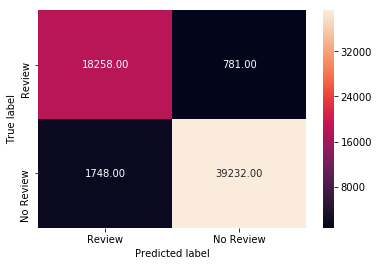

In [52]:
tree_cm = metrics.confusion_matrix( predictions_train,
                                 y_train_res, [1,0] )
sns.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Review", "No Review"] , yticklabels = ["Review", "No Review"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

    This is more accurately identifying the REVIEW =1 indicator
    19705/20006 = 98%

In [53]:
#Predicting the test cases
predictions_train_df = pd.DataFrame( { 'actual':  y_train_res,
                            'predicted': predictions_train } )

In [54]:
probs_train_df = pd.DataFrame(probs_train)

In [55]:
train_pred = pd.concat( [predictions_train_df, probs_train_df], axis = 1 )

In [56]:
train_pred.columns = ['actual', 'predicted', 'Review_0', 'Review_1']

In [57]:
train_pred.head(10)

,actual,predicted,Review_0,Review_1
0,0,0,0.960000,0.040000
1,0,1,0.479213,0.520787
2,1,1,0.366000,0.634000
3,0,0,0.940000,0.060000
4,0,0,0.500515,0.499485
5,1,1,0.240000,0.760000
6,0,0,0.920000,0.080000
7,0,0,0.840000,0.160000
8,0,0,0.720000,0.280000
9,1,1,0.100000,0.900000


In [58]:
#Score for test Datasets
score = clf.score(df_test[cols], df_test["REVIEW_IND"])
print("Accuracy: ", score)

Accuracy:  0.9132


    There are 13787 patient who are showing as anomolous -REVIEW_ID predicted as 1 (having prediction prob > 0.5)
    This is close to our objective of finding 10000 patient

    Adding test probabilities with test datasets

In [59]:
df_test["prob_true"] = probs[:, 1]

In [60]:
df_anomalous= df_test[df_test["prob_true"] > 0.5 ]
df_anomalous["prob_true"].count()

43400

In [61]:
df_anomalous.head()

,id,count,proc_1,proc_2,proc_3,proc_4,proc_5,proc_6,proc_7,proc_8,...,proc_126,proc_127,proc_128,proc_129,proc_130,INCOME_GROUP,AGE_GROUP,GENDER_GROUP,REVIEW_IND,prob_true
6,19106,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,3,0,0,0.74
14,28504,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,3,0,0,0.52
23,39897,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,2,1,0,0.62
26,41908,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,0,0,0.60
30,47601,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,4,0,0,0.76


In [62]:
df_id_review = df_anomalous['id']

**4. Refining the anomalous patient by K-MEANS Cluster Analysis**

    Using clustering determine the anomany -
    
    A. Feature importance - Using Recursive feature elmination (top 20).
    B. Using K-MEANS to check if the anomolous participants are clustering together.

    KMEANS gives us the suspicious/anamalous patients are getting clustered at Cluster 0 (highest) and Cluster 2 (next high)

#### Cluster Analysis -

   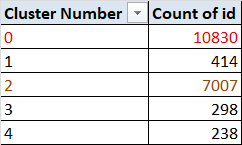

   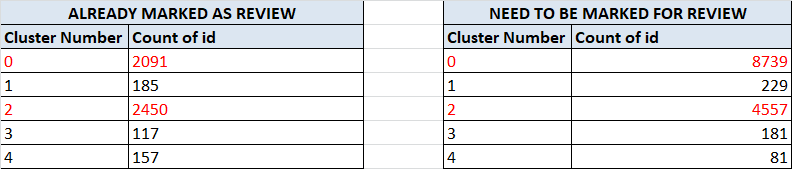

In [63]:
indices = np.argsort(clf.feature_importances_)[::-1]

In [64]:
#Using Recursive feature elmination
#The Recursive Feature Elimination (or RFE) works by recursively removing attributes and building a model on those attributes that remain.

from sklearn.feature_selection import RFE
import itertools
from itertools import zip_longest
rfc = RandomForestClassifier()

# create the RFE model and select 20 attributes
rfe = RFE(rfc, n_features_to_select=20)
rfe = rfe.fit(x_train_res, y_train_res)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), cols)]
selected_features = [v for i, v in feature_map if i==True]

In [65]:
# Selecting top 20 features for clustering
selected_features

['AGE_GROUP',
 'GENDER_GROUP',
 'INCOME_GROUP',
 'count',
 'proc_1',
 'proc_124',
 'proc_13',
 'proc_14',
 'proc_17',
 'proc_19',
 'proc_2',
 'proc_20',
 'proc_22',
 'proc_25',
 'proc_26',
 'proc_27',
 'proc_28',
 'proc_3',
 'proc_34',
 'proc_99']

**Preparing Data -**

**Merging the anomalous data with review data to check if patients are comming together in specific clusters**

In [66]:
df_subdata = df_anomalous.drop('prob_true', axis =1)

In [67]:
frames = [df_subdata, review_dataset]
medi_data = pd.concat(frames)

C:\Users\RAMKUMAR\Documents\Python Scripts\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [68]:
medi_data.head()

,AGE_GROUP,GENDER_GROUP,INCOME_GROUP,REVIEW_IND,count,id,proc_1,proc_10,proc_100,proc_101,...,proc_90,proc_91,proc_92,proc_93,proc_94,proc_95,proc_96,proc_97,proc_98,proc_99
6,3,0,4,0,3,19106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,3,0,1,0,3,28504,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,2,1,2,0,4,39897,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,2,0,1,0,4,41908,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30,4,0,1,0,2,47601,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
analysis_data = medi_data[selected_features]

In [70]:
analysis_data.head()

,AGE_GROUP,GENDER_GROUP,INCOME_GROUP,count,proc_1,proc_124,proc_13,proc_14,proc_17,proc_19,proc_2,proc_20,proc_22,proc_25,proc_26,proc_27,proc_28,proc_3,proc_34,proc_99
6,3,0,4,3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
14,3,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,2,1,2,4,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
26,2,0,1,4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
30,4,0,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [71]:
col_list = analysis_data.columns

In [72]:
col_list

Index(['AGE_GROUP', 'GENDER_GROUP', 'INCOME_GROUP', 'count', 'proc_1',
       'proc_124', 'proc_13', 'proc_14', 'proc_17', 'proc_19', 'proc_2',
       'proc_20', 'proc_22', 'proc_25', 'proc_26', 'proc_27', 'proc_28',
       'proc_3', 'proc_34', 'proc_99'],
      dtype='object')

**A. Standardizing the data**

In [73]:
from sklearn.preprocessing import StandardScaler

In [74]:
sc=StandardScaler()

In [75]:
analysis_scaled=sc.fit_transform(analysis_data)

**B. Applying PCA**

In [76]:
from sklearn.decomposition import PCA

In [77]:
var_ratio={}
for n in range(2,20):
    pc = PCA(n_components=n)
    analysis_pca=pc.fit(analysis_scaled)
    var_ratio[n]=sum(analysis_pca.explained_variance_ratio_)

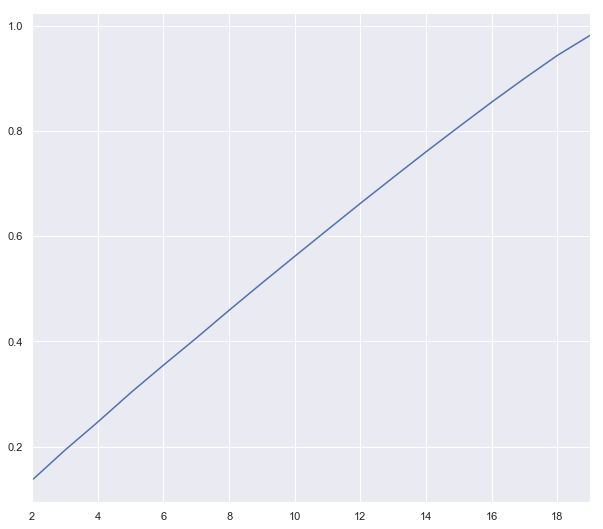

In [78]:
sns.set(rc={'figure.figsize':(10,9)})
pd.Series(var_ratio).plot()

In [79]:
var_ratio

{2: 0.13638410273220697,
 3: 0.193348565913856,
 4: 0.24684820880241115,
 5: 0.30236319647017534,
 6: 0.35493610300432915,
 7: 0.40638205446375886,
 8: 0.4592847211241804,
 9: 0.5110065179063212,
 10: 0.561855990181035,
 11: 0.6123609952649697,
 12: 0.6625752667051866,
 13: 0.7117917433897608,
 14: 0.7605697725467743,
 15: 0.8081186465111116,
 16: 0.8550374932888914,
 17: 0.9001993949584844,
 18: 0.9438073641929628,
 19: 0.9820212288417692}

In [80]:
# 16 component is defining 84% of variability
pc_final=PCA(n_components=16).fit(analysis_scaled)
reduced_cr=pc_final.fit_transform(analysis_scaled)

In [81]:
reduced_cr.shape

(48400, 16)

In [82]:
pd.DataFrame(pc_final.components_.T, columns=['PC_' + str(i) for i in range(16)], index=col_list)

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15
AGE_GROUP,0.007351,-0.559506,0.281501,0.214425,0.029170,-0.053919,-0.010474,-0.021909,-0.104982,0.018752,-0.037202,0.055981,0.201466,-0.066232,0.313678,0.143963
GENDER_GROUP,-0.032569,0.098971,-0.196906,0.547209,0.051024,0.147467,0.143997,-0.311201,0.004261,-0.169797,0.061199,-0.022245,-0.009022,0.033780,-0.230038,0.189217
INCOME_GROUP,-0.056836,0.663186,0.070763,0.124118,0.015283,-0.078927,0.014145,0.081433,-0.054134,0.014637,0.043523,-0.035305,-0.026640,0.045118,-0.102560,-0.095571
count,0.692219,0.083700,-0.041582,0.047527,0.077122,0.090440,0.008674,0.067424,-0.005486,0.099234,0.060769,-0.041017,-0.021881,-0.053682,-0.031789,-0.050185
proc_1,0.055774,0.105725,0.099468,0.049669,0.139601,0.470052,0.233311,0.187198,-0.005797,0.134124,-0.155785,-0.148282,0.086028,0.605552,0.317036,0.279053
proc_124,-0.049003,-0.000962,0.017654,0.295450,0.273413,0.342270,0.100230,0.025068,0.421152,-0.146728,-0.108867,-0.143297,0.366692,-0.342803,0.005412,-0.360608
proc_13,0.024197,-0.096559,0.129095,-0.376518,0.018369,0.515271,-0.144288,0.028645,-0.190893,-0.352423,-0.034873,-0.110816,-0.044706,-0.088395,-0.478371,0.221772
proc_14,-0.041462,0.204672,0.056757,-0.058190,-0.151286,0.058943,-0.083526,0.125894,0.219181,-0.116791,0.457702,0.565882,0.389788,0.066541,0.094075,0.227547
proc_17,-0.004401,-0.156491,-0.485496,0.109517,-0.209802,0.020397,-0.220380,0.469659,0.200931,0.304546,0.142063,-0.316752,-0.027850,0.071539,-0.113282,0.026990
proc_19,0.069344,0.054300,-0.527797,-0.027400,0.259272,0.096236,-0.127996,-0.120679,-0.300281,-0.111549,-0.319557,0.387078,-0.091773,0.060365,0.265783,-0.176624


In [83]:
pd.Series(pc_final.explained_variance_ratio_,index=['PC_' + str(i) for i in range(16)])

PC_0     0.075019
PC_1     0.062278
PC_2     0.056608
PC_3     0.055257
PC_4     0.054103
PC_5     0.052645
PC_6     0.052016
PC_7     0.051726
PC_8     0.051372
PC_9     0.050833
PC_10    0.050505
PC_11    0.050214
PC_12    0.049216
PC_13    0.048778
PC_14    0.047549
PC_15    0.046919
dtype: float64

**C. Clustering**

#### Silhouette Coefficient

In [84]:
from sklearn import metrics
from sklearn.cluster import KMeans

In [85]:
# calculate SC for K=3 through K=15
k_range = range(3, 15)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(analysis_scaled)
    scores.append(metrics.silhouette_score(analysis_scaled, km.labels_))

In [86]:
scores

[0.09124637510763021,
 0.11458693466488452,
 0.13274029657580574,
 0.13038672201844617,
 0.14784541041017818,
 0.1555094746285737,
 0.18713155717837307,
 0.18288203663765845,
 0.192837604935436,
 0.20782194639366042,
 0.21810654015241654,
 0.23431984284495372]

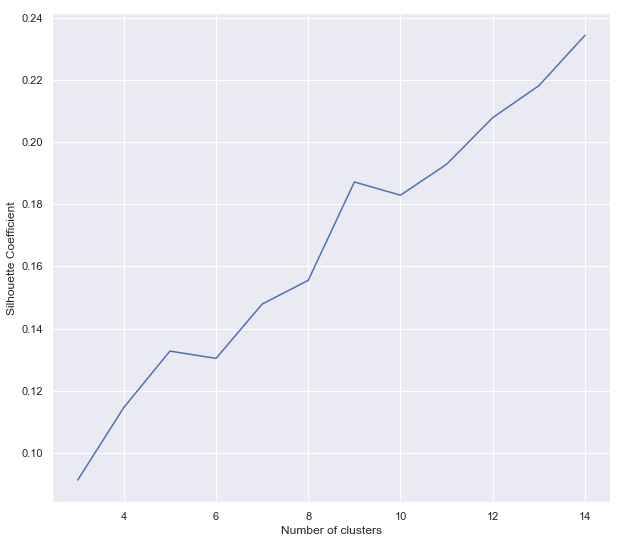

In [87]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

    Silhouette Coefficient shows 5 Cluster should be apt for the cause

#### Elbow Analysis

In [88]:
cluster_range = range( 1, 15 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( analysis_scaled )
    cluster_errors.append( clusters.inertia_ )

In [89]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

clusters_df[0:10]

,num_clusters,cluster_errors
0,1,968000.000000
1,2,914125.495316
2,3,866272.793825
3,4,819589.597402
4,5,776995.572088
5,6,730159.761488
6,7,685873.969453
7,8,645073.500090
8,9,597686.596412
9,10,571832.487257


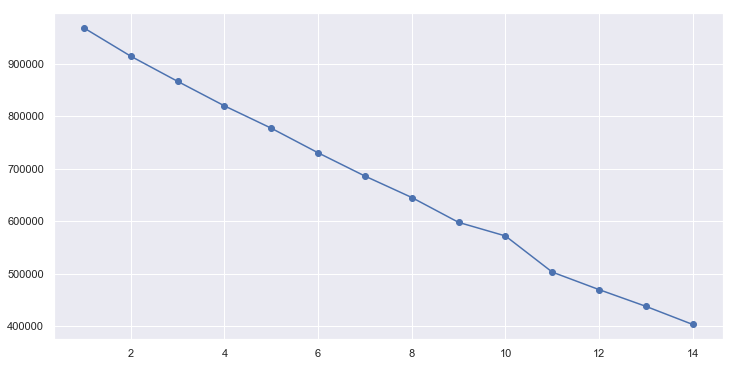

In [90]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

    The elbow diagram shows that the gain in explained variance reduces significantly from 4 to 5 to 6. So, optimal number of clusters could either 5 or 6. 

In [91]:
km_5=KMeans(init='k-means++', n_clusters=5,random_state=123)

In [92]:
km_5.fit(reduced_cr)
km_5.labels_

array([0, 3, 3, ..., 3, 3, 0])

In [93]:
pd.Series(km_5.labels_).value_counts()

3    37112
0     5387
1     4391
4     1183
2      327
dtype: int64

Text(0.5, 0, 'PC_5')

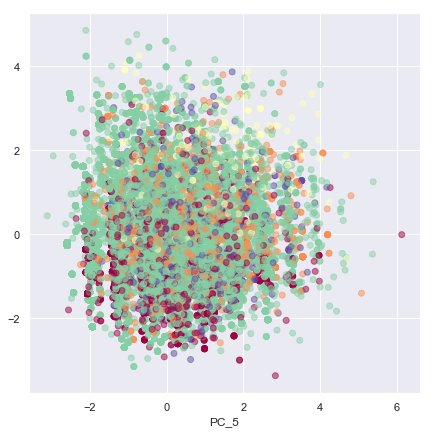

In [94]:
plt.figure(figsize=(7,7))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1], c=km_5.labels_,cmap='Spectral',alpha=0.5)
plt.xlabel('PC_5')

In [95]:
km_5 = pd.DataFrame(km_5.labels_)

In [96]:
km_5.count()

0    48400
dtype: int64

In [97]:
medi_data = medi_data.reset_index()

In [98]:
cluster_df_5= pd.concat([medi_data, km_5], axis=1)

In [99]:
cluster_df_5.rename(columns={0: 'KMEANS_5'}, inplace=True)

In [100]:
cluster_df_5.to_csv('cluster_df_5.csv')

In [101]:
cluster_df_5.head()

,index,AGE_GROUP,GENDER_GROUP,INCOME_GROUP,REVIEW_IND,count,id,proc_1,proc_10,proc_100,...,proc_91,proc_92,proc_93,proc_94,proc_95,proc_96,proc_97,proc_98,proc_99,KMEANS_5
0,6,3,0,4,0,3,19106,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14,3,0,1,0,3,28504,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,23,2,1,2,0,4,39897,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,26,2,0,1,0,4,41908,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30,4,0,1,0,2,47601,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [102]:
cluster_to_audit = cluster_df_5[['id', 'REVIEW_IND', 'KMEANS_5']]

    We see the anomalous patients are getting grouped at Cluster 0 to the highest follwed by cluster 2

   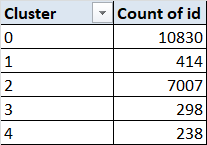

**END OF PART 3**